# Libraries

In [ ]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)
import re 
import os
import keras
import numpy as np
import pickle
import tensorflow as tf
import keras.backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import  Lambda, Input, Dense, GlobalAveragePooling1D, GlobalMaxPooling1D,Reshape, \
Activation, SimpleRNN,GRU, Bidirectional, LSTM, dot, concatenate, Dropout,Conv2D, MaxPooling2D, Flatten
from keras.layers.embeddings import Embedding
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


# Load processed data

In [ ]:
with open('/content/drive/MyDrive/Snli_project/tokenization_data.pickle', 'rb') as f:
    loaded_data = pickle.load(f)  

tokenizer = Tokenizer(char_level=False)
tokenizer.fit_on_texts(loaded_data)
max_length = 25
vocab_size = len(tokenizer.word_index)

In [ ]:
with open('/content/drive/MyDrive/Snli_project/train_data.pickle', 'rb') as f:
      preproc_premise, preproc_hypothesis, Y_train = pickle.load(f)

with open('/content/drive/MyDrive/Snli_project/test_data.pickle', 'rb') as f:
      preproc_premise_T, preproc_hypothesis_T, Y_test = pickle.load(f)         

# Glove

In [ ]:
EMBEDDING_DIM = 300
GLOVE_DIR = '/content/drive/MyDrive/Snli_project/Glove'
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.300d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

  

Found 400000 word vectors.


In [ ]:
oov=0
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        std = 1.0
        mean = 0.0
        embedding_matrix[i] = std * np.random.randn(300) + mean
        oov +=1
print(oov)        

# Equations

In [ ]:
# a = np.arange(0.0, 30.0, 1.0).reshape(2, 3, 5)
# b = np.arange(20.0, 50.0, 1.0).reshape(2, 3, 5)
# aTb = keras.layers.Dot(axes=(2, 2))([a, b])
# aTb_T = tf.linalg.matrix_transpose(aTb)
# segma_col = K.sum(aTb , axis=1)
# segma_col = Reshape(( 3,-1), input_shape=segma_row.shape)(segma_col)

# alpha_summation = tf.divide(aTb_T, segma_col)
# alpha = keras.layers.Dot(axes=(2, 1))([alpha_summation, a])

In [ ]:
# a = np.arange(0.0, 30.0, 1.0).reshape(2, 3, 5)
# b = np.arange(20.0, 50.0, 1.0).reshape(2, 3, 5)
# aTb = keras.layers.Dot(axes=(2, 2))([a, b])

# segma_row = K.sum(aTb , axis=2)
# segma_row = Reshape(( 3,-1), input_shape=segma_row.shape)(segma_row)
# beta_summation = tf.divide(aTb, segma_row)
# beta = keras.layers.Dot(axes=(2, 1))([beta_summation, b])

# Model

In [ ]:
import keras
EMBEDDING_DIM = 300
def get_model():
  
    inp1 = Input((max_length,))
    inp2 = Input((max_length,))
    
    a = Embedding(vocab_size+1, EMBEDDING_DIM, weights=[embedding_matrix],
                                  input_length=max_length, trainable=False, mask_zero=True)(inp1)
    b = Embedding(vocab_size+1, EMBEDDING_DIM, weights=[embedding_matrix],
                                  input_length=max_length, trainable=False, mask_zero=True)(inp2)

    a = tf.math.l2_normalize(x=a, axis = 2)
    b = tf.math.l2_normalize(x=b, axis = 2)
    a = Dense(200)(a)
    a = Dropout(0.2)(a)
    b = Dense(200)(b) 
    b = Dropout(0.2)(b)                                  
    #************************************** Attend ***********************************
    aTb = keras.layers.Dot(axes=(2, 2))([a, b])
    exp_aTb = tf.math.exp(aTb)
    exp_aTb_T = tf.linalg.matrix_transpose(aTb)

    segma_row = K.sum(exp_aTb, axis=2)
    segma_row = Reshape(( max_length,-1), input_shape=segma_row.shape)(segma_row)
    beta_summation = tf.divide(exp_aTb, segma_row)
    beta = keras.layers.Dot(axes=(2, 1), name='beta')([beta_summation, b])

    segma_col = K.sum(exp_aTb, axis=1)
    segma_col = Reshape(( max_length,-1), input_shape = segma_col.shape)(segma_col)
    alpha_summation = tf.divide(exp_aTb_T, segma_col)
    alpha = keras.layers.Dot(axes=(2, 1), name='alpha')([alpha_summation, a])
      
    # ****************************** compare *******************************************
    v1_i = concatenate([a, beta])
    v2_j = concatenate([b, alpha])
    
    G1 = Dense(256, activation="relu")(v1_i) 
    G1 = Dropout(0.2)(G1)
    G1 = Dense(256, activation="relu")(G1) 
    G1 = Dropout(0.2)(G1)
    G1 = Dense(256, activation="relu", name='G1')(G1) 
    G1 = Dropout(0.2)(G1)
    
    G2 = Dense(256, activation="relu")(v2_j)
    G2 = Dropout(0.2)(G2)
    G2 = Dense(256, activation="relu")(G2)
    G2 = Dropout(0.2)(G2)
    G2 = Dense(256, activation="relu", name='G2')(G2)
    G2 = Dropout(0.2)(G2)
    #******************************** Aggregate *****************************************                       
    v1 = Lambda(lambda x: K.sum(x , axis=1))(G1)
    v2 = Lambda(lambda x: K.sum(x , axis=1))(G2)

    v = concatenate([v1, v2])
    H = Dense(128, activation="relu")(v)
    H = Dropout(0.2)(H)
    H = Dense(128, activation="relu")(H)
    H = Dropout(0.2)(H)
    H = Dense(64, activation="relu")(H)
    
    outp = Dense(3, activation="softmax", name="final_output")(H)
    
    model = Model(inputs=[inp1,inp2], outputs=outp)
    model.compile(loss='categorical_crossentropy',
                  optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.05,
                                              initial_accumulator_value=0.1,
                                              epsilon=1e-07), metrics=['accuracy'])

    return model

In [ ]:
model = get_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 25)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 25)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 25, 300)      10083000    ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 25, 300)      10083000    ['input_2[0][0]']                
                                                                                              

                                                                                                  
 dropout_7 (Dropout)            (None, 25, 256)      0           ['G2[0][0]']                     
                                                                                                  
 lambda (Lambda)                (None, 256)          0           ['dropout_4[0][0]']              
                                                                                                  
 lambda_1 (Lambda)              (None, 256)          0           ['dropout_7[0][0]']              
                                                                                                  
 concatenate_2 (Concatenate)    (None, 512)          0           ['lambda[0][0]',                 
                                                                  'lambda_1[0][0]']               
                                                                                                  
 dense_6 (

In [ ]:
# learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=1, 
#                                             verbose=1, factor=0.1, min_lr=0.0001)
early = EarlyStopping(monitor="val_accuracy", mode="max", patience=7, restore_best_weights=True)
model_callbacks = [early]

model_history = model.fit([preproc_premise, preproc_hypothesis],Y_train,
                                  batch_size=4, 
                                  epochs=60,
                                  validation_split = 0.2,
                                  callbacks = model_callbacks)

Epoch 1/60
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
111836/111841 [============================>.] - ETA: 0s - loss: 0.8895 - accuracy: 0.5873WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f0e8c0a7d40> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=1

111841/111841 [==============================] - 697s 6ms/step - loss: 0.4375 - accuracy: 0.8304 - val_loss: 0.4584 - val_accuracy: 0.8227
Epoch 43/60
111841/111841 [==============================] - 697s 6ms/step - loss: 0.4370 - accuracy: 0.8296 - val_loss: 0.4556 - val_accuracy: 0.8237
Epoch 44/60
111841/111841 [==============================] - 696s 6ms/step - loss: 0.4365 - accuracy: 0.8300 - val_loss: 0.4515 - val_accuracy: 0.8251
Epoch 45/60
111841/111841 [==============================] - 697s 6ms/step - loss: 0.4347 - accuracy: 0.8306 - val_loss: 0.4537 - val_accuracy: 0.8236
Epoch 46/60
111841/111841 [==============================] - 697s 6ms/step - loss: 0.4336 - accuracy: 0.8314 - val_loss: 0.4514 - val_accuracy: 0.8248
Epoch 47/60
111841/111841 [==============================] - 698s 6ms/step - loss: 0.4339 - accuracy: 0.8316 - val_loss: 0.4538 - val_accuracy: 0.8239
Epoch 48/60
111841/111841 [==============================] - 697s 6ms/step - loss: 0.4320 - accuracy: 0.83

In [ ]:
model.save("models/Attention_model.h5")

In [ ]:
%%time
import numpy as np
test_pred = model.predict([preproc_premise_T, preproc_hypothesis_T], batch_size=128)
i = 0
for x,y in zip(np.argmax(test_pred, axis=1), np.argmax(Y_test, axis=1)):
    if x == y:
        i += 1
test_acc = i/Y_test.shape[0] * 100
print("Accuracy on test set is: %"+str(test_acc))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Accuracy on test set is: %83.80496742671009
CPU times: user 9.72 s, sys: 287 ms, total: 10 s
Wall time: 1.99 s


In [ ]:
import matplotlib.pyplot as plt
def eval_metric(model, history, metric_name,model_nam):

    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]
    e = range(1, NB_START_EPOCHS + 1)
    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.xlabel('Epoch number')
    plt.ylabel(metric_name)
    plt.title('Comparing training and validation ' + metric_name+' ' +model_nam)
    plt.legend()
    plt.show()

def optimal_epoch(model_hist):
    min_epoch = np.argmin(model_hist.history['val_loss']) + 1
    print("Minimum validation loss reached in epoch {}".format(min_epoch))
    return min_epoch     

Minimum validation loss reached in epoch 46


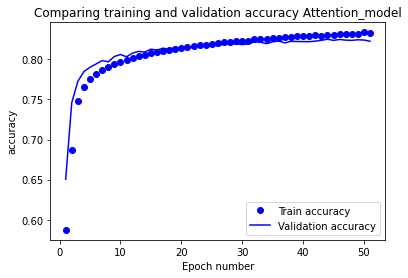

In [ ]:
NB_START_EPOCHS = 51
reduced_min = optimal_epoch(model_history)
eval_metric(model, model_history, 'accuracy', 'Attention_model')

Minimum validation loss reached in epoch 46


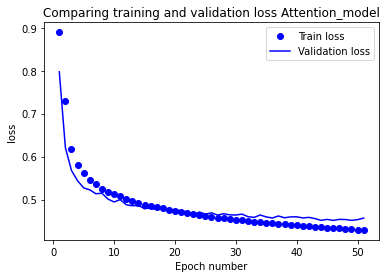

In [ ]:
NB_START_EPOCHS = 51
reduced_min = optimal_epoch(model_history)
eval_metric(model, model_history, 'loss', 'Attention_model')